In [1]:
import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt
import os

## Voyager Telemetry Demodulation

In [2]:
def string_to_binary(string):
    return ''.join(format(x, '08b') for x in bytearray(string, 'utf-8'))

In [3]:
def binary_to_string(binary):
    ba = []
    for i in range(len(binary)//8):
        ba.append(int(binary[i*8:(i+1)*8], base=2))
    return ascii(''.join([ chr(c) for c in ba]))[1:-1]

In [4]:
def decode_msg(t, f, freq_carrier, samples_per_period, plot=False):
    """
    Decodes the message
    
    DO NOT CHANGE THIS FUNCTION
    
    @param t: time
    @param f: signal
    @param freq_carrier: carrier frequency
    @param samples_per_period: number of samples per period
    @param plot: show plot
    @return None
    """
    h = signal.hilbert(f)
    dt = np.mean(np.diff(t))
    phase_shift = np.unwrap(np.angle(h)) - 2*freq_carrier*np.pi*t
    phase_shift = (phase_shift + np.pi) % (2 * np.pi) - np.pi
    b, a = signal.butter(2, freq_carrier*0.1, 'lp', fs=1/dt)
    signal.bode(b, a)
    filtered = signal.lfilter(b, a, phase_shift)
    scale = np.max(filtered) - np.min(filtered)
    scaled = (filtered - np.min(filtered))/scale
    k_eval = np.array(0.5*samples_per_period + np.arange(0, len(t), samples_per_period), dtype=np.int)
    if plot:
        plt.plot(1e9*t, scaled, label='phase shift filtered')
        plt.vlines(t[k_eval]*1e9, 0, 1, color='r', linestyle='--', label='eval')
        plt.xlabel('t, nanoseconds')
        plt.legend()
    binary = np.array(scaled[k_eval] > 0.5, dtype=np.int)
    if plot:
        for i in range(len(binary)):
            plt.text(t[k_eval[i]]*1e9, 1, str(binary[i]))
    return binary_to_string(''.join([str(c) for c in binary]))

In [5]:
# NOTE: you must set the path to your data file here
data = np.loadtxt('data/voyager_signal.csv', delimiter=',')

my message was: "V'ger"


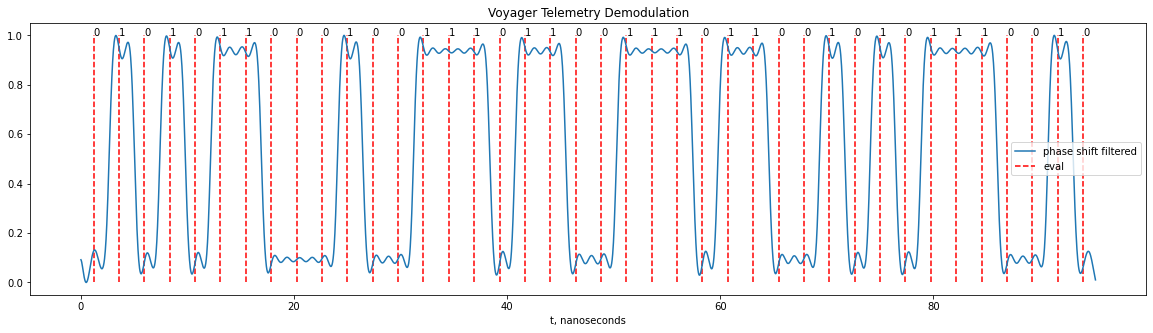

In [6]:
t = data[:, 0]
f = data[:, 1]
plt.figure(figsize=(20, 5))
plt.title('Voyager Telemetry Demodulation')
msg = decode_msg(t=t, f=f, freq_carrier=8.4e9, samples_per_period=100, plot=True)

if not os.path.exists('./fig'):
    os.mkdir('./fig')
plt.savefig('fig/voyager_decode.png')
print('my message was: "{:s}"'.format(msg))